In [80]:
import pandas as pd
from numpy import array
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler


### Import Data

In [108]:
train_sales = pd.read_csv(r'C:/Users/Student/Desktop/competitive-data-science-predict-future-sales/sales_train.csv', parse_dates=['date'], infer_datetime_format=True, dayfirst=True)
test_sales = pd.read_csv(r'C:/Users/Student/Desktop/competitive-data-science-predict-future-sales/test.csv')
print(train_sales.shape)
print(test_sales.shape)

(2935849, 6)
(214200, 3)


### Preprocessing

In [ ]:
train_sales['date'] = train_sales.date.apply(lambda x: x.strftime('%Y-%m'))
train_sales['item_cnt_day']=train_sales['item_cnt_day'].clip(0,round(train_sales['item_cnt_day'].mean()+5*(train_sales['item_cnt_day'].std())))
train_sales.loc[train_sales[train_sales['item_price']<0].index, 'item_price']=0
#Scale the price column 
scaler = MinMaxScaler(feature_range=(0, 1))
train_sales["item_price"] = scaler.fit_transform(train_sales["item_price"].values.reshape(-1,1))

### Create pivot dataframes for price and day count separately

In [82]:
train_sales_price = train_sales.groupby(['date','shop_id', 'item_id']).mean().reset_index()
train_sales_price = train_sales_price.pivot_table(index=['shop_id', 'item_id'], columns='date', values='item_price', fill_value=0).reset_index()
train_sales_price = pd.merge(test_sales, train_sales_price, on=['shop_id', 'item_id'], how='left').fillna(0)
train_sales_price = train_sales_price.drop(columns=['shop_id', 'item_id', 'ID'])

In [84]:
train_sales_cnt = train_sales.groupby(['date','shop_id', 'item_id']).sum()
train_sales_cnt = train_sales_cnt.pivot_table(index=['shop_id', 'item_id'], columns='date', values='item_cnt_day', fill_value=0).reset_index()
train_sales_cnt = pd.merge(test_sales, train_sales_cnt, on=['shop_id', 'item_id'], how='left').fillna(0)
train_sales_cnt = train_sales_cnt.drop(columns=['shop_id', 'item_id', 'ID'])

date,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424119,59,22154,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
424120,59,22155,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
424121,59,22162,0,0,0,0,0,0,0,0,...,0,9,4,1,1,0,0,1,0,0
424122,59,22164,0,0,0,0,0,0,0,0,...,0,2,1,2,0,0,1,0,0,0


### Transformed into numpy array for data structure of sequential model

In [86]:
train_sales_price_x= train_sales_price.drop(columns='2015-10')
train_sales_price_y= train_sales_price['2015-10']
train_sales_cnt_x= train_sales_cnt.drop(columns='2015-10')
train_sales_cnt_y= train_sales_cnt['2015-10']
train_sales_price_x=train_sales_price_x.values.reshape((train_sales_price_x.shape[0], train_sales_price_x.shape[1], 1))
train_sales_cnt_x=train_sales_cnt_x.values.reshape((train_sales_cnt_x.shape[0], train_sales_cnt_x.shape[1], 1))
train_sales_cnt_y=train_sales_cnt_y.values.reshape((train_sales_cnt_x.shape[0], 1))

### Combine two arrays into one

In [87]:
train_sales_combined_x = np.append(train_sales_price_x,train_sales_cnt_x,axis = 2)
train_sales_y = train_sales_cnt_y
print(train_sales_combined_x.shape)
print(train_sales_y.shape)

(214200, 33, 2)
(214200, 1)


### Validation Set

In [89]:
#Date range of valudation dataset restricted from 2013-02 to 2015-10
valid_price=train_sales_price.drop(columns='2013-01')
valid_itemcnt=train_sales_cnt.drop(columns='2013-01')
valid_price=valid_price.values.reshape((valid_price.shape[0], valid_price.shape[1], 1))
valid_itemcnt=valid_itemcnt.values.reshape((valid_itemcnt.shape[0], valid_itemcnt.shape[1], 1))
valid_combined = np.append(valid_price,valid_itemcnt,axis = 2)
print(valid_combined.shape)

### Train Test Split

In [107]:
x_train, x_valid, y_train, y_valid = train_test_split(train_sales_combined_x, train_sales_y, test_size=0.10)

### Sequential Model Setting

In [140]:
model=Sequential()
model.add(LSTM(25, input_shape=(33,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 33, 25)            2700      
_________________________________________________________________
dropout_4 (Dropout)          (None, 33, 25)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                15200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 17,951
Trainable params: 17,951
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(train_sales_combined_x, train_sales_y, verbose=1, epochs=15, batch_size=512)

Train on 214200 samples
Epoch 1/15
214200/214200 [==============================] - 16s 75us/sample - loss: 0.1302 - mse: 0.1302
Epoch 2/15
214200/214200 [==============================] - 15s 69us/sample - loss: 0.1252 - mse: 0.1252
Epoch 3/15
214200/214200 [==============================] - 14s 67us/sample - loss: 0.1244 - mse: 0.1244
Epoch 4/15
214200/214200 [==============================] - 14s 67us/sample - loss: 0.1238 - mse: 0.1238
Epoch 5/15
214200/214200 [==============================] - 14s 68us/sample - loss: 0.1238 - mse: 0.1238
Epoch 6/15
214200/214200 [==============================] - 14s 67us/sample - loss: 0.1238 - mse: 0.1238
Epoch 7/15
214200/214200 [==============================] - 14s 67us/sample - loss: 0.1241 - mse: 0.1241
Epoch 8/15
214200/214200 [==============================] - 14s 67us/sample - loss: 0.1237 - mse: 0.1237
Epoch 9/15
214200/214200 [==============================] - 15s 69us/sample - loss: 0.1235 - mse: 0.1235
Epoch 10/15
214200/214200 [====

In [106]:
model = Sequential()
model.add(LSTM(25, input_shape=(train_sales_combined_x.shape[1], train_sales_combined_x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 33, 16)            1216      
_________________________________________________________________
dropout_4 (Dropout)          (None, 33, 16)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________
None


Train on 192780 samples, validate on 21420 samples
Epoch 1/15
192780/192780 [==============================] - 23s 120us/sample - loss: 3.5284 - mse: 3.5284 - val_loss: 0.5291 - val_mse: 0.5291
Epoch 2/15
192780/192780 [==============================] - 22s 112us/sample - loss: 3.4232 - mse: 3.4232 - val_loss: 0.5150 - val_mse: 0.5150
Epoch 3/15
192780/192780 [==============================] - 21s 111us/sample - loss: 3.4014 - mse: 3.4014 - val_loss: 0.5078 - val_mse: 0.5078
Epoch 4/15
192780/192780 [==============================] - 21s 111us/sample - loss: 3.4102 - mse: 3.4102 - val_loss: 0.4903 - val_mse: 0.4903
Epoch 5/15
192780/192780 [==============================] - 21s 110us/sample - loss: 3.3382 - mse: 3.3382 - val_loss: 0.4860 - val_mse: 0.4860
Epoch 6/15
192780/192780 [==============================] - 22s 114us/sample - loss: 3.3468 - mse: 3.3468 - val_loss: 0.4926 - val_mse: 0.4926
Epoch 7/15
192780/192780 [==============================] - 22s 115us/sample - loss: 3.2814

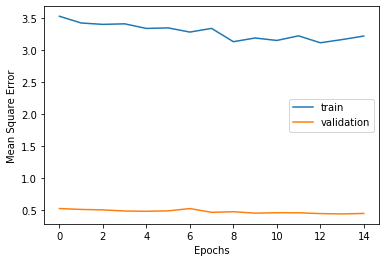

In [104]:
callbacks=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=10,mode='auto')]
LSTM = model.fit(x_train, y_train,
                 validation_data=(x_valid, y_valid),
                 callbacks=callbacks,
                 batch_size=512, verbose=1, epochs=15)

plt.plot(LSTM.history['loss'], label='train')
plt.plot(LSTM.history['val_loss'], label='validation')
plt.xlabel("Epoch")
plt.ylabel("mse")
plt.legend()
plt.show()
print("Optimal Epoch: {}",np.argmin(hist.history["val_loss"]))
print("Train: {}, Validation: {}".format(LSTM.history["loss"][np.argmin(hist.history["val_loss"])],LSTM.history["val_loss"][np.argmin(hist.history["val_loss"])]))

In [101]:
test_sales['item_cnt_month']=model.predict(valid_combined)
test_sales = test_sales.set_index('ID')
test_sales=test_sales.drop(columns=['shop_id', 'item_id'])
test_sales.to_csv(r'C:\Users\Student\Desktop\usedcar\test_result.csv')